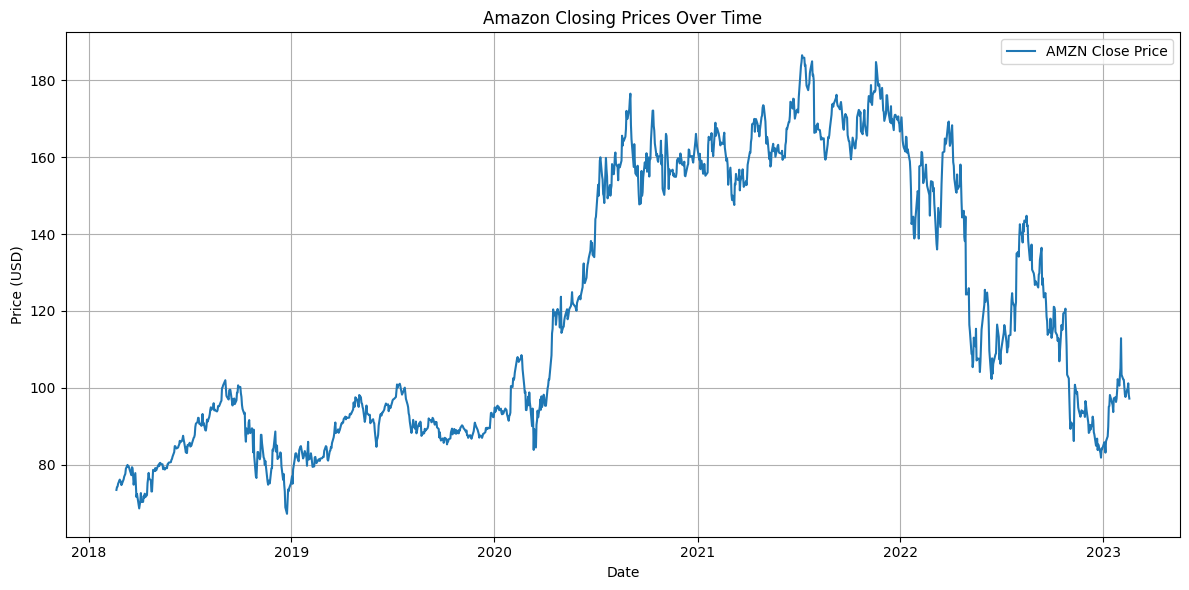

ADF Test p-value: 0.45297105465166737
KPSS Test p-value: 0.01
ADF after Differencing p-value: 0.0
KPSS after Differencing p-value: 0.1


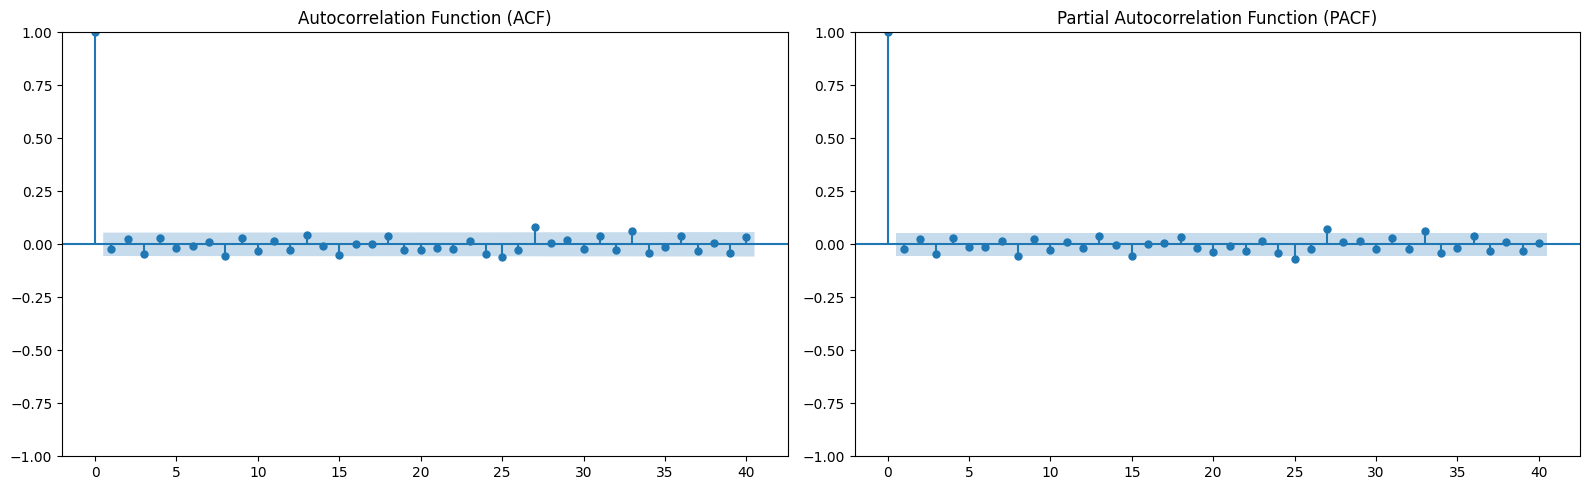

Best ARIMA model (p,d,q): (2, 1, 2)
ARIMA Evaluation on Test Set (Last 24 Days):
MAE : 2.9318
RMSE: 4.2158
MAPE: 0.0285


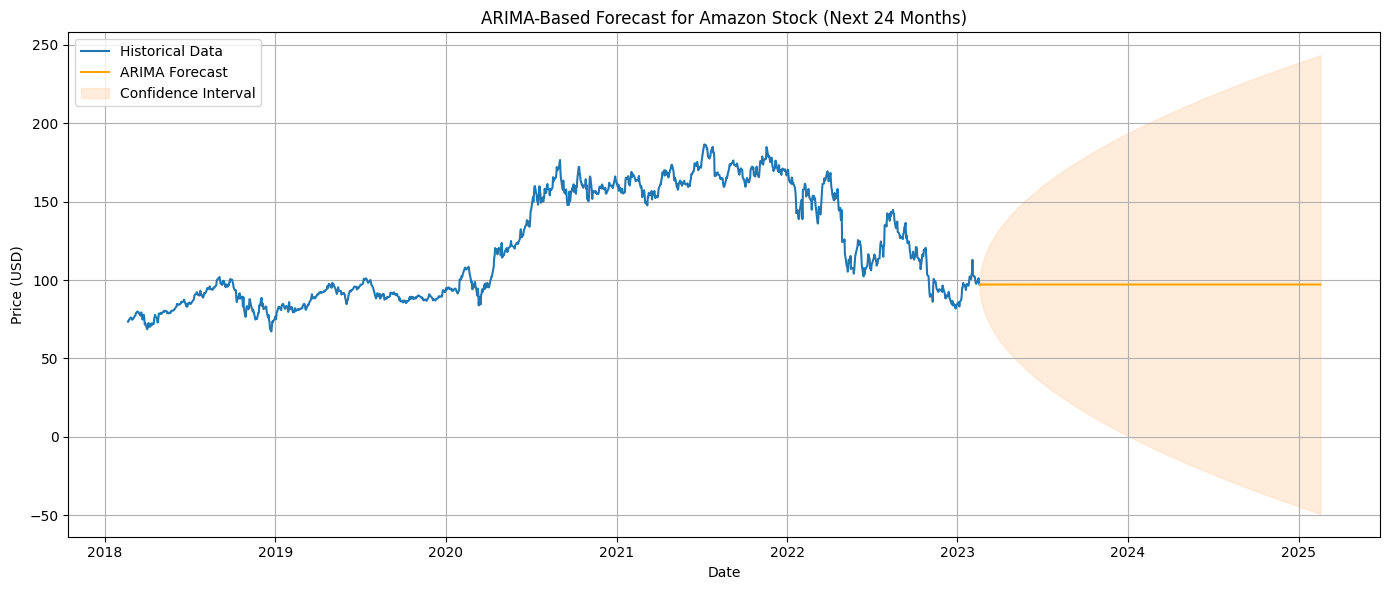

In [ ]:
# --- Libraries for Time Series Forecasting ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------------
# Step 1: Load and Visualize Stock Dataset
# ----------------------------------------
amazon_data = pd.read_csv("AMZN.csv")
amazon_data['Date'] = pd.to_datetime(amazon_data['Date'])
amazon_data.set_index('Date', inplace=True)

# Extract closing prices for analysis
closing_prices = amazon_data[['Close']]

# Visualize the raw closing prices
plt.figure(figsize=(12, 6))
plt.plot(closing_prices, color='darkblue', label='Amazon Closing Price')
plt.title('Amazon Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------
# Step 2: Stationarity Tests (ADF and KPSS)
# -------------------------------------------
adf_result = adfuller(closing_prices['Close'])
kpss_result = kpss(closing_prices['Close'], regression='c', nlags='auto')

print("ADF Test p-value:", adf_result[1])
print("KPSS Test p-value:", kpss_result[1])

# ---------------------------------------------------
# Step 3: Apply Differencing to Achieve Stationarity
# ---------------------------------------------------
price_diff = closing_prices.diff().dropna()

# Re-run stationarity tests on differenced series
adf_diff_result = adfuller(price_diff['Close'])
kpss_diff_result = kpss(price_diff['Close'], regression='c', nlags='auto')

print("ADF after Differencing p-value:", adf_diff_result[1])
print("KPSS after Differencing p-value:", kpss_diff_result[1])

# -----------------------------------------------
# Step 4: Plot ACF and PACF for Model Selection
# -----------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(price_diff, lags=40, ax=ax[0])
ax[0].set_title("ACF (Autocorrelation)")
plot_pacf(price_diff, lags=40, ax=ax[1])
ax[1].set_title("PACF (Partial Autocorrelation)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Step 5: Use Grid Search to Find Optimal ARIMA Parameters
# ---------------------------------------------------------
lowest_aic = np.inf
best_order = None
best_arima_model = None

for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(closing_prices['Close'], order=(p, 1, q)).fit()
            if model.aic < lowest_aic:
                lowest_aic = model.aic
                best_order = (p, 1, q)
                best_arima_model = model
        except:
            continue

print("Optimal ARIMA (p,d,q):", best_order)

# ----------------------------------------------------------------
# Step 6: Forecast the Next 730 Days (Approx. 24 Months Forward)
# ----------------------------------------------------------------
forecast_obj = best_arima_model.get_forecast(steps=730)
forecast_values = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int()

last_date = closing_prices.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=730, freq='D')

# ------------------------------------------------------------------
# Step 7: Create Train-Test Split for Backtesting (Last 24 Samples)
# ------------------------------------------------------------------
test_size = 24
train_data = closing_prices[:-test_size]
test_data = closing_prices[-test_size:]

# Train ARIMA model again on training portion
train_model = ARIMA(train_data['Close'], order=best_order).fit()
test_forecast = train_model.get_forecast(steps=test_size)
test_predictions = test_forecast.predicted_mean

# ---------------------------------------------------
# Step 8: Evaluate Predictions with Standard Metrics
# ---------------------------------------------------
true_values = test_data['Close'].values
predicted_values = test_predictions.values

mae = mean_absolute_error(true_values, predicted_values)
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
mape = mean_absolute_percentage_error(true_values, predicted_values)

print("Evaluation on Last 24 Days:")
print("MAE :", round(mae, 4))
print("RMSE:", round(rmse, 4))
print("MAPE:", round(mape, 4))

# ------------------------------------------------
# Step 9: Visualize Forecast with Confidence Bands
# ------------------------------------------------
plt.figure(figsize=(14, 6))
plt.plot(closing_prices.index, closing_prices['Close'], label='Historical Data', color='darkblue')
plt.plot(future_dates, forecast_values, label='ARIMA Forecast', color='orangered')
plt.fill_between(future_dates,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='lightsteelblue', alpha=0.5, label='95% Confidence Interval')
plt.title('Forecast of Amazon Stock Prices (Next 24 Months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**RNN Model**

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.1157 - val_loss: 0.0054
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0035 - val_loss: 0.0060
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0016 - val_loss: 0.0048
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0013 - val_loss: 0.0048
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0012 - val_loss: 0.0039
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0

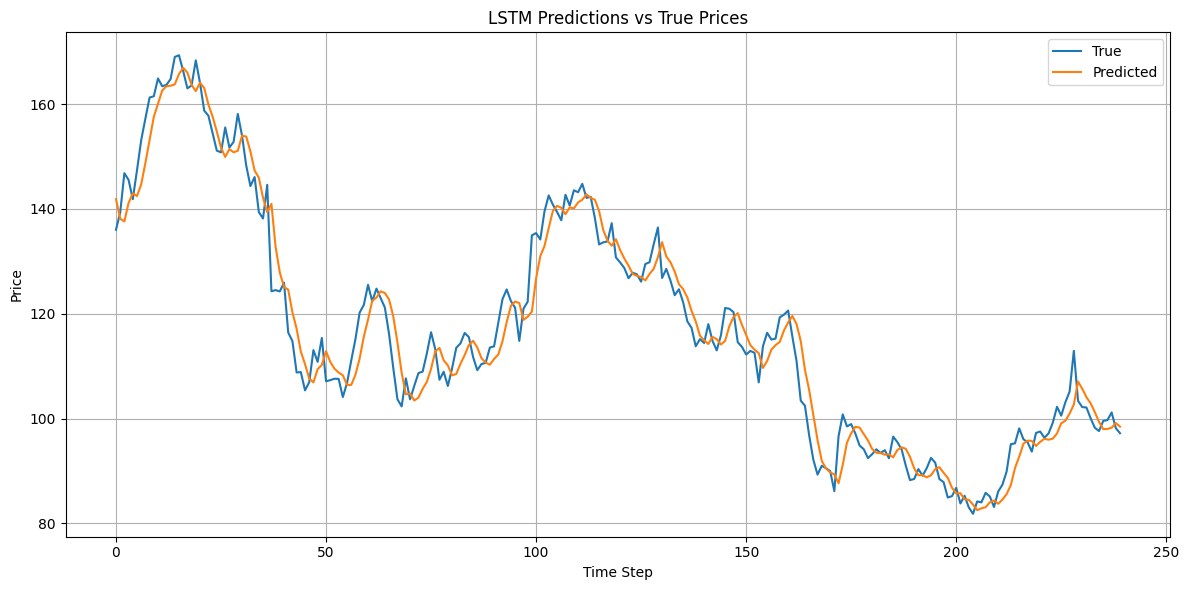

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
LSTM Model Performance:
MAE : 3.4865682593465164
RMSE: 4.434343870030947
MAPE: 0.03013505717069522


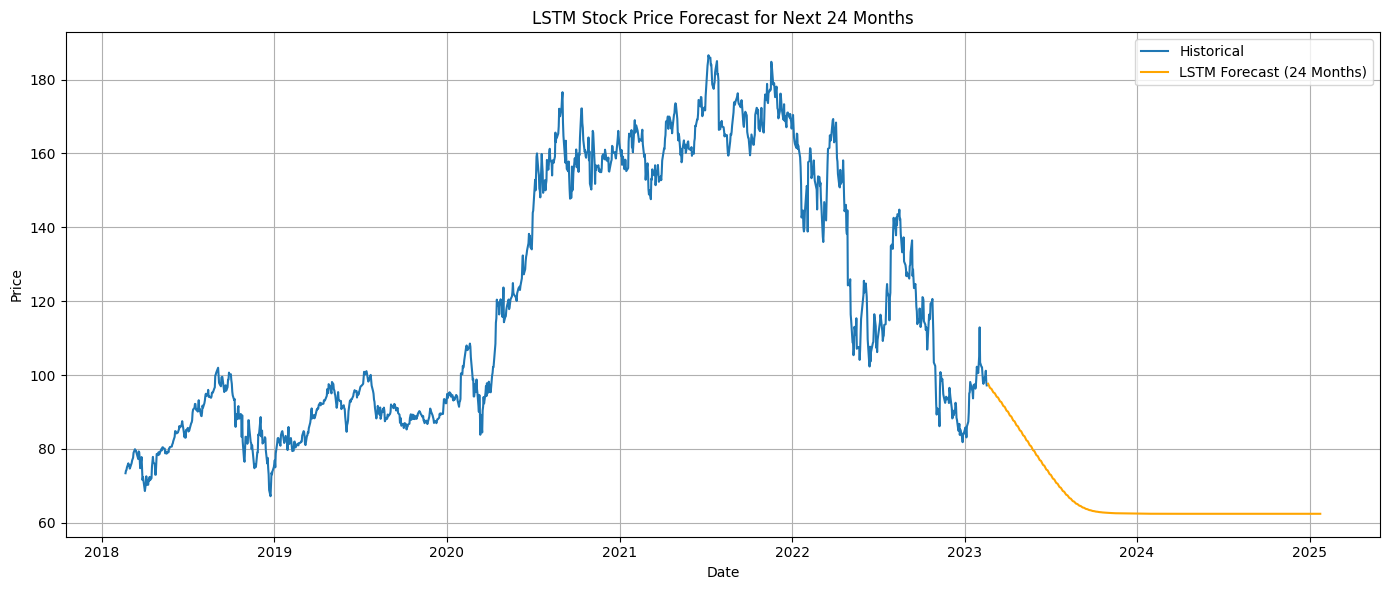

In [ ]:
# -------------------------------
# Import Required Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

# -------------------------------
# Load and Preprocess Data
# -------------------------------
amazon_df = pd.read_csv("AMZN.csv")
amazon_df['Date'] = pd.to_datetime(amazon_df['Date'])
amazon_df.set_index('Date', inplace=True)
close_data = amazon_df[['Close']].copy()

# Normalize the 'Close' prices
scaler = MinMaxScaler()
close_data['Close'] = scaler.fit_transform(close_data[['Close']])

# -------------------------------
# Create Input Sequences
# -------------------------------
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(close_data['Close'].values, sequence_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

# -------------------------------
# Split Data into Training and Testing Sets
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# -------------------------------
# Define and Train LSTM Model
# -------------------------------
model_lstm = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# -------------------------------
# Plot Predictions vs Actual
# -------------------------------
def plot_predictions(model, X_test, y_test, title_label="LSTM"):
    predictions = model.predict(X_test)
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='True Price', color='midnightblue')
    plt.plot(scaler.inverse_transform(predictions), label='Predicted Price', color='goldenrod')
    plt.title(f"{title_label} Predictions vs Actual Prices")
    plt.xlabel("Time Step")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_predictions(model_lstm, X_test, y_test)

# -------------------------------
# Evaluate LSTM Model Performance
# -------------------------------
predicted_scaled = model_lstm.predict(X_test)
true_prices = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
predicted_prices = scaler.inverse_transform(predicted_scaled).flatten()

mae = mean_absolute_error(true_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(true_prices, predicted_prices))
mape = mean_absolute_percentage_error(true_prices, predicted_prices)

print("LSTM Model Performance Metrics:")
print("MAE :", round(mae, 4))
print("RMSE:", round(rmse, 4))
print("MAPE:", round(mape, 4))

# -------------------------------
# Forecast Future Prices (504 business days ≈ 24 months)
# -------------------------------
def forecast_future_prices(model, past_data, n_days=504, seq_len=60):
    recent_sequence = past_data[-seq_len:].reshape(1, seq_len, 1)
    forecast = []

    for _ in range(n_days):
        next_pred = model.predict(recent_sequence, verbose=0)[0][0]
        forecast.append(next_pred)
        recent_sequence = np.append(recent_sequence[:, 1:, :], [[[next_pred]]], axis=1)

    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

future_forecast = forecast_future_prices(model_lstm, close_data['Close'].values, n_days=504)

# -------------------------------
# Create Future Dates and Plot Forecast
# -------------------------------
future_dates = pd.date_range(start=close_data.index[-1] + pd.DateOffset(days=1), periods=504, freq='B')

plt.figure(figsize=(14, 6))
plt.plot(close_data.index, scaler.inverse_transform(close_data['Close'].values.reshape(-1, 1)),
         label='Historical Data', color='darkgreen')
plt.plot(future_dates, future_forecast, label='LSTM Forecast (24 Months)', color='goldenrod')
plt.title('LSTM Forecast of Amazon Stock Prices (Next 24 Months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.1528 - val_loss: 0.0044
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0060 - val_loss: 0.0019
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 7.6268e-04 - val_loss: 0.0018
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 6.9305e-04 - val_loss: 0.0018
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 6.8315e-04 - val_loss: 0.0017
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 6.1203e-04 - val_loss: 0.0016
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 7.1106e-04 - val_loss: 0.0017
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 6.1791e-04 - val_loss: 0.0015
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 6.2311e-04 - val_loss: 0.0014
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 6.1202e-04 - val_loss: 0.0015
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 6.7814e-04 - val_loss: 0.0014
Epoch 12/50
30/30 ━━━━━━━━━

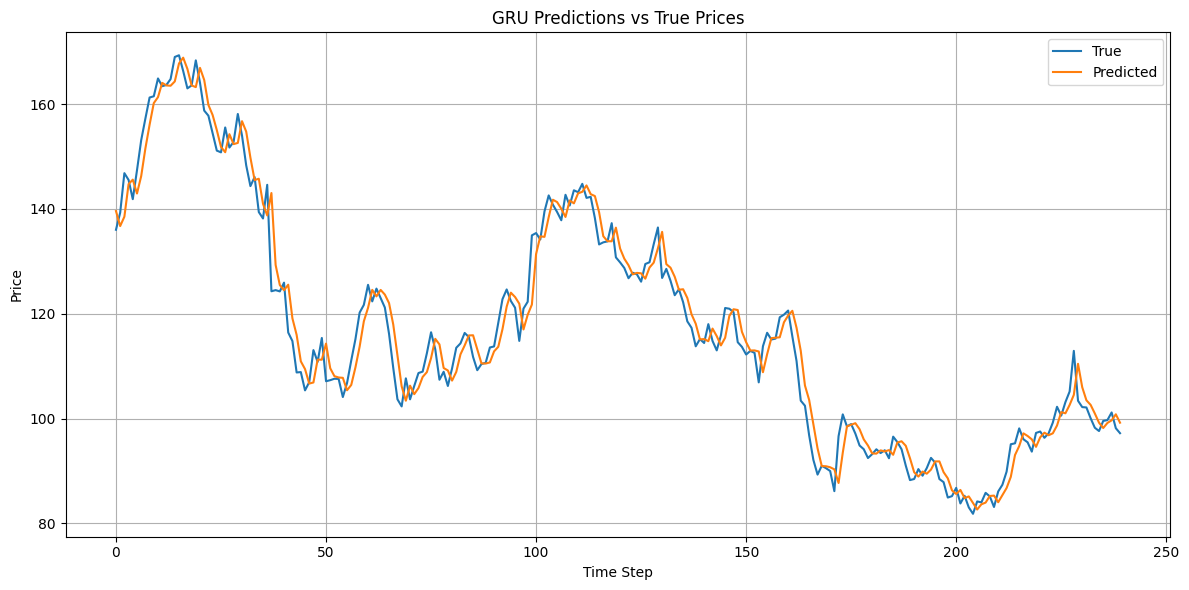

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
GRU Model Performance:
MAE : 2.991182708174642
RMSE: 3.886943669824334
MAPE: 0.025812245507554947


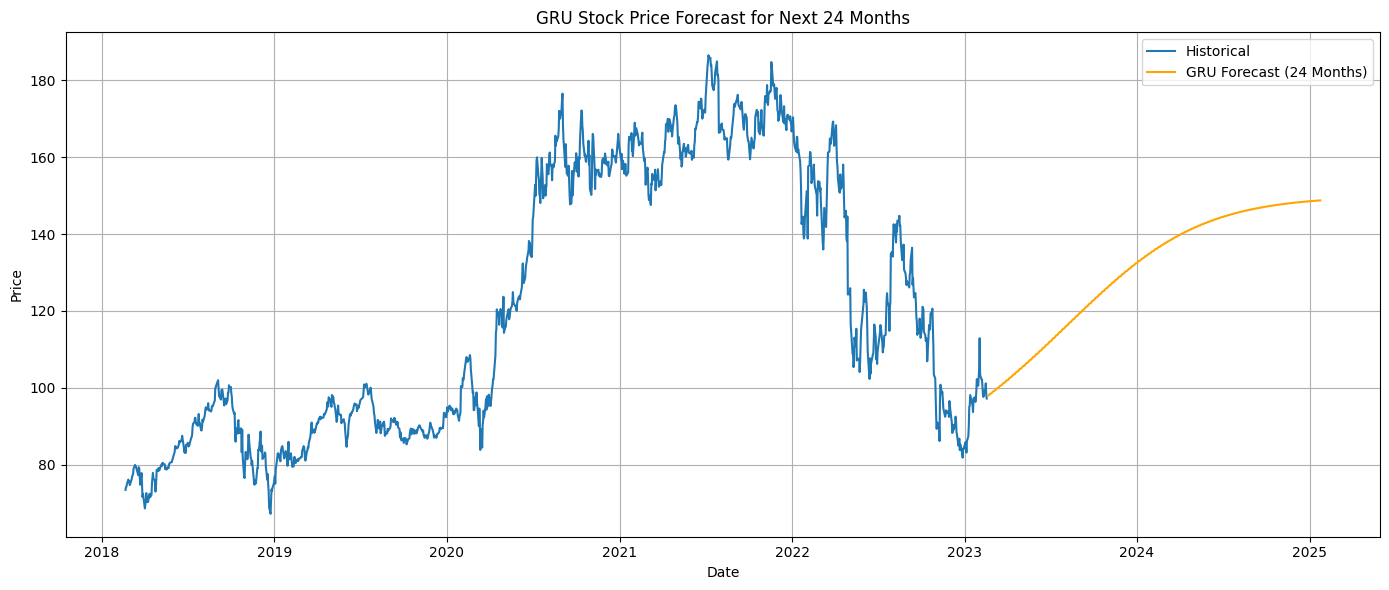

In [ ]:
# -------------------------------
# Import Required Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

# -------------------------------
# Load and Normalize Data
# -------------------------------
amazon_df = pd.read_csv("AMZN.csv")
amazon_df['Date'] = pd.to_datetime(amazon_df['Date'])
amazon_df.set_index('Date', inplace=True)
close_data = amazon_df[['Close']].copy()

# Normalize using MinMaxScaler
scaler = MinMaxScaler()
close_data['Close'] = scaler.fit_transform(close_data[['Close']])

# -------------------------------
# Generate Sequences for Time Series Input
# -------------------------------
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(close_data['Close'].values, sequence_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

# -------------------------------
# Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# -------------------------------
# Define and Train GRU Model
# -------------------------------
model_gru = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

model_gru.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_gru.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# -------------------------------
# Plot GRU Model Predictions
# -------------------------------
def plot_predictions(model, X_test, y_test, label="GRU"):
    predictions = model.predict(X_test)
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Price', color='slategray')
    plt.plot(scaler.inverse_transform(predictions), label='Predicted Price', color='darkred')
    plt.title(f"{label} Model: Actual vs Predicted")
    plt.xlabel("Time Step")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_predictions(model_gru, X_test, y_test)

# -------------------------------
# Evaluate Model Performance
# -------------------------------
gru_pred_scaled = model_gru.predict(X_test)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
predicted_prices = scaler.inverse_transform(gru_pred_scaled).flatten()

mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mape = mean_absolute_percentage_error(actual_prices, predicted_prices)

print("GRU Model Evaluation Metrics:")
print("MAE :", round(mae, 4))
print("RMSE:", round(rmse, 4))
print("MAPE:", round(mape, 4))

# -------------------------------
# Forecasting Future Prices (Next 504 Business Days)
# -------------------------------
def forecast_future_prices(model, past_data, forecast_horizon=504, seq_len=60):
    last_seq = past_data[-seq_len:].reshape(1, seq_len, 1)
    forecast = []

    for _ in range(forecast_horizon):
        next_val = model.predict(last_seq, verbose=0)[0][0]
        forecast.append(next_val)
        last_seq = np.append(last_seq[:, 1:, :], [[[next_val]]], axis=1)

    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

future_forecast = forecast_future_prices(model_gru, close_data['Close'].values)

# -------------------------------
# Create Forecast Date Index and Plot Results
# -------------------------------
future_index = pd.date_range(start=close_data.index[-1] + pd.DateOffset(days=1), periods=504, freq='B')

plt.figure(figsize=(14, 6))
plt.plot(close_data.index, scaler.inverse_transform(close_data['Close'].values.reshape(-1, 1)),
         label='Historical Prices', color='seagreen')
plt.plot(future_index, future_forecast, label='GRU Forecast (24 Months)', color='darkred')
plt.title('GRU Forecast for Amazon Stock (Next 24 Months)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
